# Direction of Arrival: CNN and GLRT Prediction

In [ ]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import to_categorical

from preprocessing import load_doa2_data, load_steering_vectors
from cnn import CNN_DOA
from doa import evaluate_doa_predictions, convert_signals_to_covariance_input

## Load and Preprocess Data

In [2]:
filepaths = [
    '../data/original/signals_for_doa.mat',
    '../data/original/signals_for_doa-2.mat',
    '../data/original/signals_for_doa-3.mat'
]

X_train, X_test, y_train, y_test, doa2s = load_doa2_data(filepaths)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (24000, 8, 1500, 2)
Testing data shape: (6000, 8, 1500, 2)


In [3]:
np.savez_compressed('../data/original/signals_for_doa.npz',
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    doa2s=doa2s
)
print("Saved as compressed .npz.")

Saved as compressed .npz.


In [3]:
data = np.load('../data/original/signals_for_doa.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
doa2s = data['doa2s']

In [4]:
steering_matrix, DoAs = load_steering_vectors(filepath='../data/original/steering_matrix.mat')
print(f"Steering matrix shape: {steering_matrix.shape}")
print(f"DoAs shape: {DoAs.shape}")

Steering matrix shape: (8, 61)
DoAs shape: (61,)


In [5]:
# Convert the signals to covariance input
X_train_cov = convert_signals_to_covariance_input(X_train, turn_on_time=750, block_size=750)
X_test_cov = convert_signals_to_covariance_input(X_test, turn_on_time=750, block_size=750)

# One-hot encode the target DoA class labels
y_train_onehot = to_categorical(y_train, num_classes=61)
y_test_onehot = to_categorical(y_test, num_classes=61)

## GLRT

In [6]:
tolerance = 0
acc, preds = evaluate_doa_predictions(X_test_cov, y_test_onehot, steering_matrix, tolerance=tolerance)
print(f"Test accuracy with ±{tolerance} DoA tolerance: {acc:.4f}")

Test accuracy with ±0 DoA tolerance: 0.8625


In [15]:
doa_pred_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': preds,
})
doa_pred_df.to_csv('../results/noattack/glrt_doa_predictions.csv')
print("DoA predictions saved to ../results/noattack/glrt_doa_predictions.csv")

DoA predictions saved to ../results/noattack/glrt_doa_predictions.csv


In [14]:
doa_accuracy_df = pd.DataFrame([{
    'tolerance': tolerance,
    'test_accuracy': acc
}])
doa_accuracy_df.to_csv('../results/noattack/glrt_doa_accuracy.csv')
print("Saved DoA accuracy to ../results/noattack/glrt_doa_accuracy.csv")

Saved DoA accuracy to ../results/noattack/glrt_doa_accuracy.csv


#### Check error

In [7]:
incorrect_mask = np.abs(preds - y_test) > tolerance
incorrect_indices = np.where(incorrect_mask)[0]

df_errors = pd.DataFrame({
    "Index": incorrect_indices,
    "Predicted": preds[incorrect_indices],
    "True": y_test[incorrect_indices],
    "Error": np.abs(preds[incorrect_indices] - y_test[incorrect_indices])
})
df_errors

,Index,Predicted,True,Error
0,2,16,46,30
1,5,38,7,31
2,7,43,13,30
3,9,43,13,30
4,14,2,35,33
...,...,...,...,...
820,5959,25,58,33
821,5971,2,35,33
822,5982,5,37,32
823,5983,44,14,30


<Axes: >

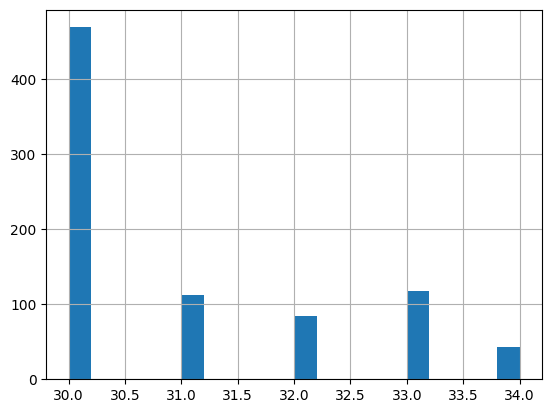

In [8]:
df_errors['Error'].hist(bins=20)

## CNN

In [7]:
# Train the CNN model on covariance input
model, history = CNN_DOA(
    X_train_cov,
    y_train_onehot,
    model_name='cnn_doa_cov',
    save_dir='../models/noattack',
    num_classes=61
)


Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5360 - loss: 1.5197 - val_accuracy: 0.8427 - val_loss: 0.5878 - learning_rate: 0.0010
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8716 - loss: 0.2660 - val_accuracy: 0.9156 - val_loss: 0.1713 - learning_rate: 0.0010
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9033 - loss: 0.2041 - val_accuracy: 0.9015 - val_loss: 0.1754 - learning_rate: 0.0010
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9145 - loss: 0.1683 - val_accuracy: 0.9287 - val_loss: 0.1187 - learning_rate: 0.0010
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9210 - loss: 0.1603 - val_accuracy: 0.9463 - val_loss: 0.1049 - learning_rate: 0.0010
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9308 - loss: 0.1404 - val_accuracy: 0.9369 - val_loss: 0.1144 - learning_rate: 0.0010
Epoch 7/20
598/600 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9405 - loss: 0.1223
Epoch 7: Redu

In [8]:
test_loss, test_accuracy = model.evaluate(X_test_cov, y_test_onehot)
print(f'CNN Test accuracy: {test_accuracy:.4f}')

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9513 - loss: 0.0720
CNN Test accuracy: 0.9543
